## Estimation of Pore Pressure in the Krishna-Godavari Basin Using Machine Learning

Pore pressure refers to the pressure of fluids within the pore spaces of rocks or soils, playing a crucial role in determining rock stability, strength, and fluid flow behavior. Accurate measurement of pore pressure is essential for understanding geomechanical processes and is typically achieved using piezometers, pressure transducers, or laboratory-based porometry techniques. The Karasjok Greenstone Belt (KGB) in northern Norway is a linear, rift-related belt of highly deformed and metamorphosed metavolcanic and metasedimentary rocks, formed during the Palaeoproterozoic era and affected by major tectonic events, making it significant for both geological research and mineral exploration

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

In [2]:
a = pd.read_csv('well data.csv')
a.head()

,DEPTH,GR,RHOB,Vp,Vsh,Caliper,Porosity,Resistivity,Stress,PP
0,22.0024,57.3820,1.4506,1.4614,0.033808,11.4844,66.1596,0.7881,312783.4781,1609.0
1,22.1548,58.0070,1.4506,1.4594,0.044766,11.4844,66.1591,0.7751,314949.9782,1609.0
2,22.3072,59.1046,1.4506,1.4577,0.064012,11.4844,66.1585,0.7798,317116.4783,1609.0
3,22.4596,59.2124,1.4506,1.4567,0.065902,11.4844,66.1581,0.7711,319282.9784,1609.0
4,22.6120,59.8294,1.4506,1.4564,0.076721,11.4844,66.1575,0.7446,321449.4786,1609.0


In [3]:
a.shape

(11494, 10)

In [4]:
a.describe()

,DEPTH,GR,RHOB,Vp,Vsh,Caliper,Porosity,Resistivity,Stress,PP
count,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,1.149400e+04,11494.000000
mean,139.708824,92.087422,1.805392,-25.703265,0.661127,10.091069,59.443962,0.987094,2.535401e+06,1840.075003
std,74.660054,8.951782,0.135371,162.894928,0.451688,0.632879,6.693833,0.266715,1.450494e+06,219.426644
min,5.948800,42.267500,1.082400,-999.250000,-0.162116,9.415300,41.174600,0.357000,6.647748e+04,1416.000000
25%,78.177400,87.600575,1.737000,1.511500,0.575324,9.777000,54.937325,0.839525,1.376452e+06,1668.000000
50%,132.923800,92.628000,1.816700,1.537000,0.672497,9.967150,58.791100,0.951200,2.353846e+06,1823.000000
75%,191.025100,97.888425,1.900200,1.580200,0.757985,10.245500,63.029525,1.090200,3.424687e+06,2006.000000
max,335.882800,114.995600,2.117400,1.724800,46.208200,16.375000,98.848500,2.869200,6.932513e+06,2314.000000


In [5]:
a.isnull().sum()

DEPTH          0
GR             0
RHOB           0
Vp             0
Vsh            0
Caliper        0
Porosity       0
Resistivity    0
Stress         0
PP             0
dtype: int64

Null values are not there

In [6]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11494 entries, 0 to 11493
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DEPTH        11494 non-null  float64
 1   GR           11494 non-null  float64
 2   RHOB         11494 non-null  float64
 3   Vp           11494 non-null  float64
 4   Vsh          11494 non-null  float64
 5   Caliper      11494 non-null  float64
 6   Porosity     11494 non-null  float64
 7   Resistivity  11494 non-null  float64
 8   Stress       11494 non-null  float64
 9   PP           11494 non-null  float64
dtypes: float64(10)
memory usage: 898.1 KB


Outliers checking

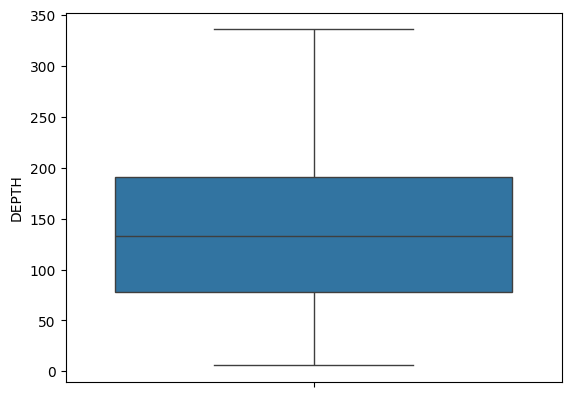

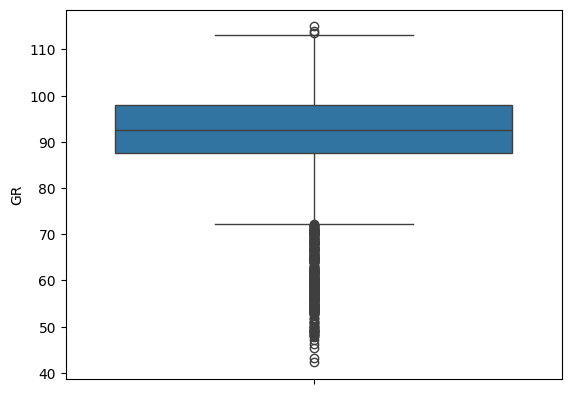

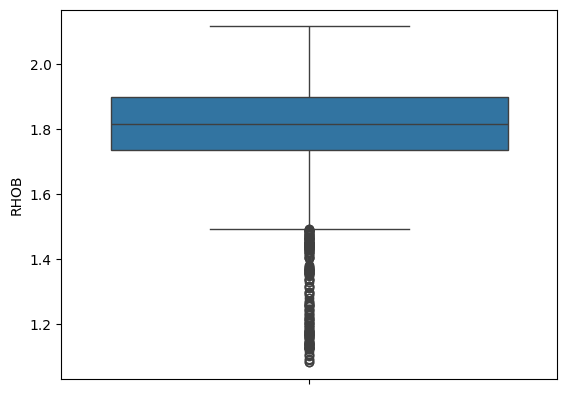

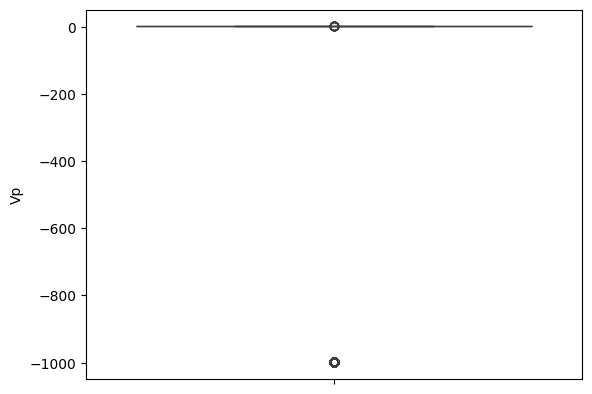

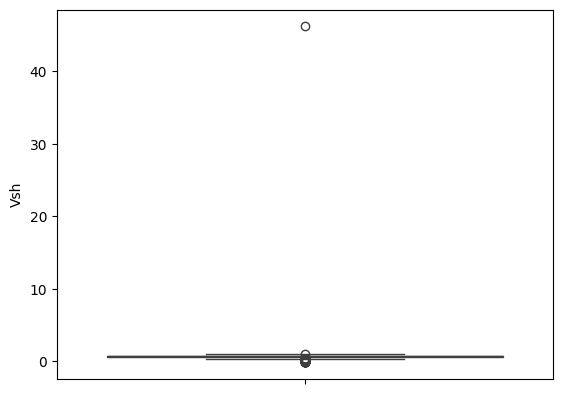

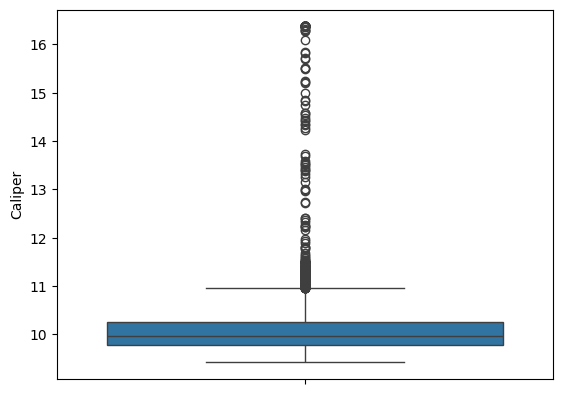

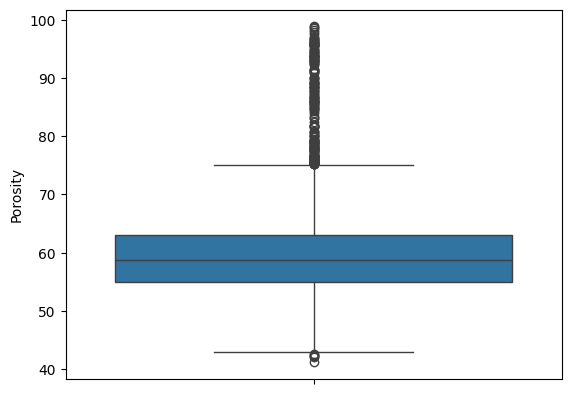

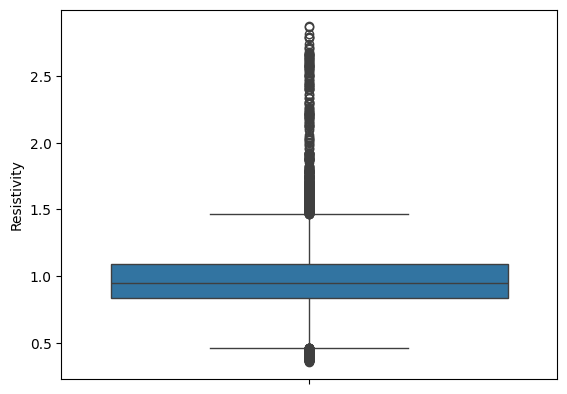

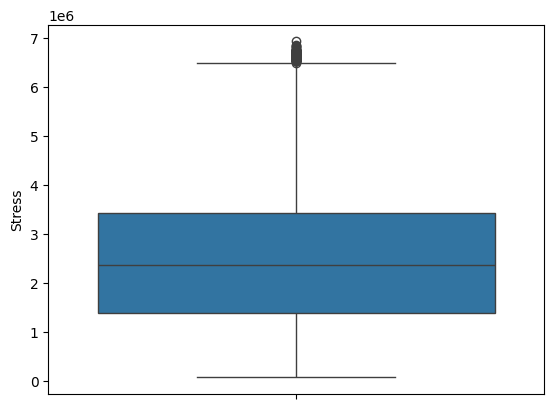

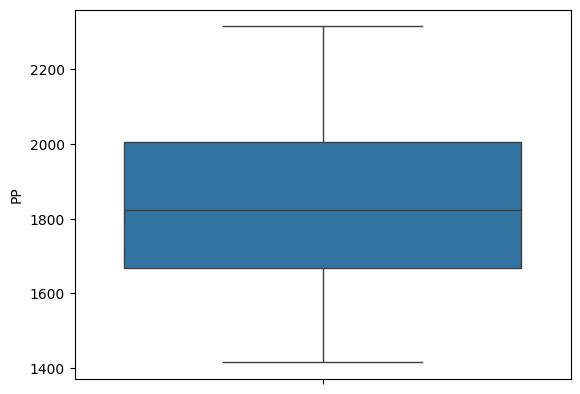

In [7]:
cols = a.columns

for col in cols:
    plt.figure()
    sns.boxplot(a[col])

In [8]:
# def remove_outliers_iqr(a, columns):
#     for col in columns:
#         Q1 = a[col].quantile(0.25)
#         Q3 = a[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         a[col] = np.where((a[col] < lower_bound) | (
#             a[col] > upper_bound), np.nan, a[col])
#     return a


# cols = a.columns
# a = remove_outliers_iqr(a, cols)

I initially tried using the IQR method for outlier removal (see commented code above), but found that it resulted in some features having all their values replaced with NaN, so only 7 out of 10 features remained for analysis and visualization. To address this, I decided to comment out the IQR approach and use a less restrictive method instead, which allowed me to retain all features for a more comprehensive analysis

In [9]:
a.loc[a['GR'] < 70, 'GR'] = np.nan
a.loc[a['RHOB'] < 1.5, 'RHOB'] = np.nan
a.loc[a['Vp'] > 1.70, 'Vp'] = np.nan
a.loc[a['Vsh'] < 0.37, 'Vsh'] = np.nan
a.loc[a['Caliper'] > 11, 'Caliper'] = np.nan
a.loc[a['Porosity'] > 75, 'Porosity'] = np.nan
a.loc[a['Resistivity'] > 1.5, 'Resistivity'] = np.nan

In [10]:
a = a.dropna()

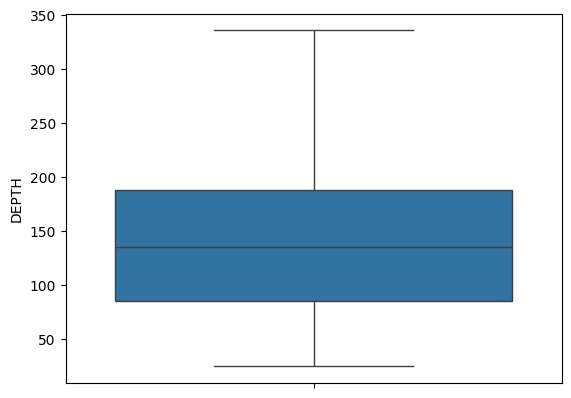

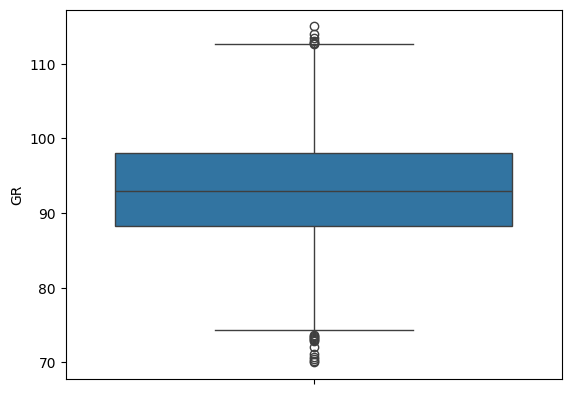

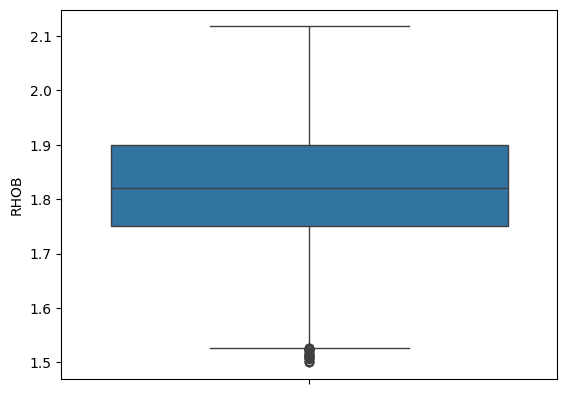

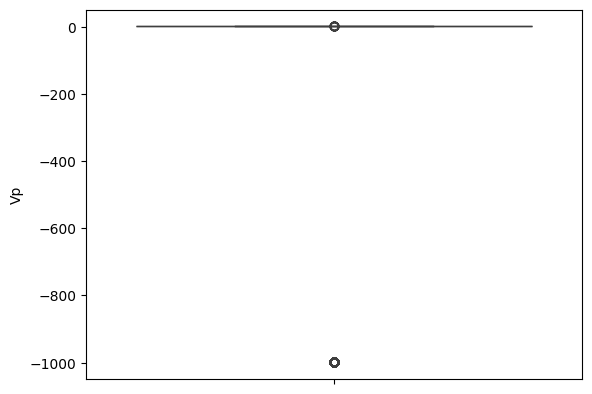

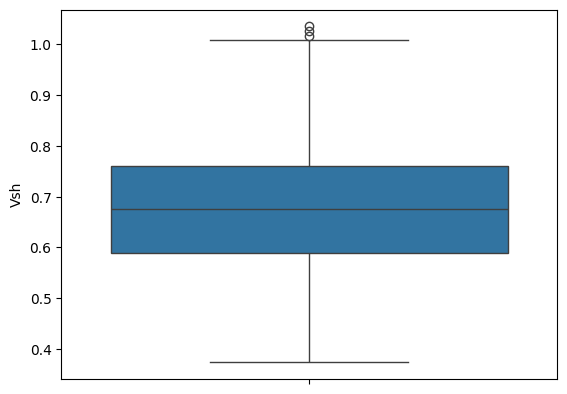

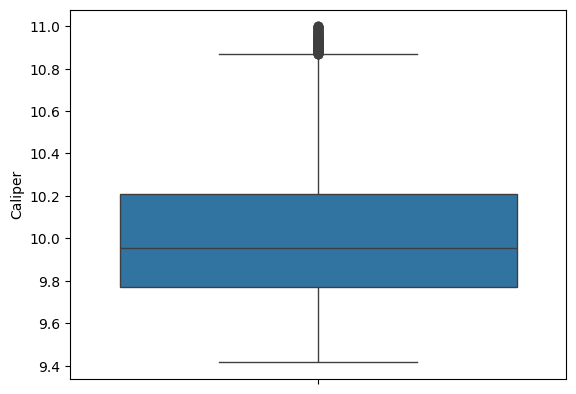

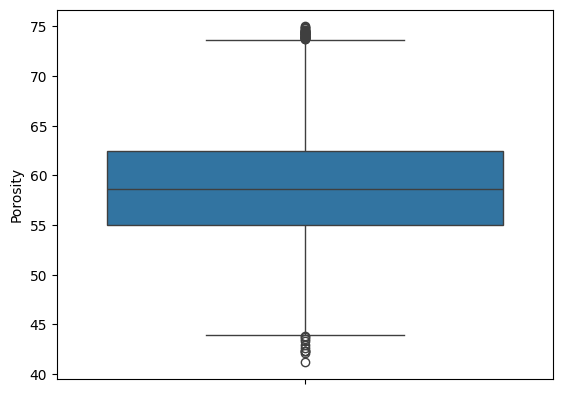

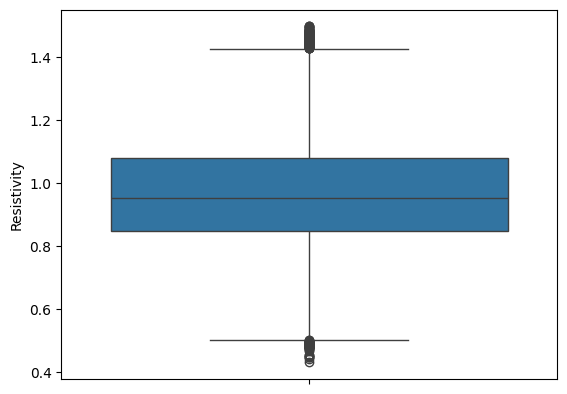

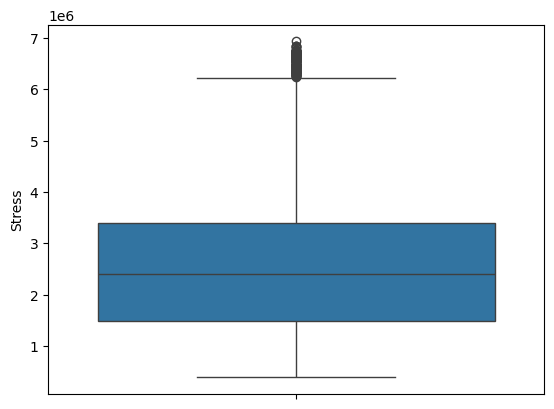

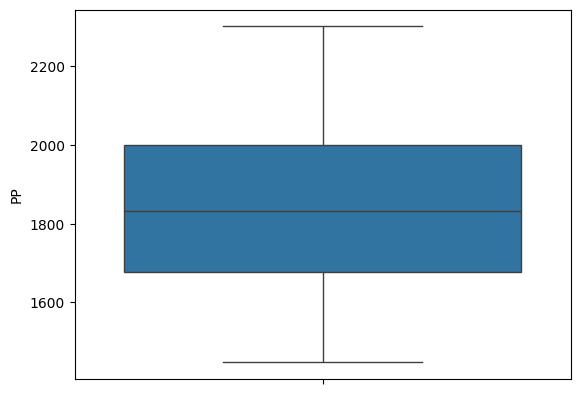

In [11]:
for col in cols:
    plt.figure()
    sns.boxplot(a[col])

Outliers are handled

In [12]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
scaled = scale.fit_transform(a[['GR', 'RHOB', 'Vp', 'Vsh', 'Caliper', 'Porosity',
                                'Resistivity', 'Stress']])

In [13]:
cols = ['GR', 'RHOB', 'Vp', 'Vsh', 'Caliper', 'Porosity',
        'Resistivity', 'Stress']
scaled_a = pd.DataFrame(scaled, columns=cols)

In [14]:
a = a.reset_index()

In [15]:
scaled_a

,GR,RHOB,Vp,Vsh,Caliper,Porosity,Resistivity,Stress
0,0.095351,0.087316,0.999789,0.002970,0.937192,0.726727,0.314069,0.017649
1,0.277994,0.098007,0.999792,0.187648,0.930059,0.804398,0.334395,0.018335
2,0.146424,0.144986,0.999797,0.230534,0.858793,0.764288,0.363338,0.023780
3,0.047101,0.162644,0.999799,0.173578,0.860497,0.803269,0.391064,0.024718
4,0.152046,0.136724,0.999803,0.194618,0.917498,0.804055,0.391907,0.025682
...,...,...,...,...,...,...,...,...
10403,0.785251,0.543010,0.999793,0.792334,0.335059,0.307047,0.641158,0.438688
10404,0.752223,0.525514,0.999783,0.760394,0.313344,0.405877,0.649401,0.436171
10405,0.738662,0.506561,0.999777,0.747281,0.258553,0.327461,0.659329,0.433404
10406,0.732966,0.477726,0.999770,0.741773,0.277238,0.356041,0.671132,0.428971


In [16]:
merge = [a['DEPTH'], a['PP'], scaled_a]
pd.concat(merge, axis=1)
a_scaled = pd.concat(merge, axis=1)

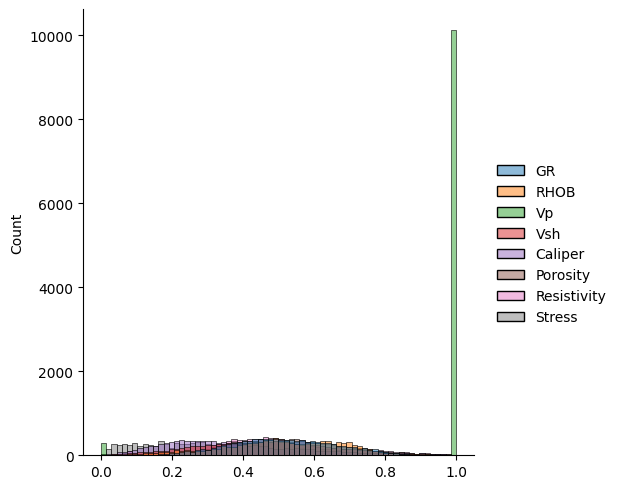

In [17]:
sns.displot(a_scaled[['GR', 'RHOB', 'Vp', 'Vsh', 'Caliper', 'Porosity',
                      'Resistivity', 'Stress']])

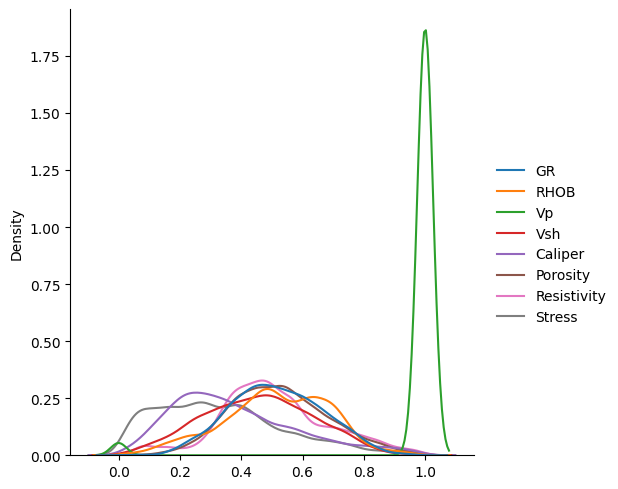

In [18]:
sns.displot(a_scaled[['GR', 'RHOB', 'Vp', 'Vsh', 'Caliper', 'Porosity',
                      'Resistivity', 'Stress']], kind="kde")

Our Data is ready for model development

In [19]:
# Feature engineering and selection
a = a_scaled.drop(['Vp'], axis=1)
a

,DEPTH,PP,GR,RHOB,Vsh,Caliper,Porosity,Resistivity,Stress
0,33.2800,1617.0,0.095351,0.087316,0.002970,0.937192,0.726727,0.314069,0.017649
1,33.4324,1620.0,0.277994,0.098007,0.187648,0.930059,0.804398,0.334395,0.018335
2,35.1088,1621.0,0.146424,0.144986,0.230534,0.858793,0.764288,0.363338,0.023780
3,35.2612,1620.0,0.047101,0.162644,0.173578,0.860497,0.803269,0.391064,0.024718
4,36.0232,1622.0,0.152046,0.136724,0.194618,0.917498,0.804055,0.391907,0.025682
...,...,...,...,...,...,...,...,...,...
10403,181.3026,1805.0,0.785251,0.543010,0.792334,0.335059,0.307047,0.641158,0.438688
10404,181.4550,1805.0,0.752223,0.525514,0.760394,0.313344,0.405877,0.649401,0.436171
10405,181.6074,1803.0,0.738662,0.506561,0.747281,0.258553,0.327461,0.659329,0.433404
10406,181.7598,1808.0,0.732966,0.477726,0.741773,0.277238,0.356041,0.671132,0.428971


In [20]:
a.corr()

,DEPTH,PP,GR,RHOB,Vsh,Caliper,Porosity,Resistivity,Stress
DEPTH,1.000000,0.709591,0.228171,0.596943,0.183359,-0.470626,-0.529550,0.512857,0.995396
PP,0.709591,1.000000,0.297317,0.618000,0.327807,-0.467341,-0.562232,0.654209,0.725342
GR,0.228171,0.297317,1.000000,0.448181,0.928665,-0.216557,-0.427141,0.200921,0.249181
RHOB,0.596943,0.618000,0.448181,1.000000,0.447860,-0.482734,-0.870870,0.442243,0.653090
Vsh,0.183359,0.327807,0.928665,0.447860,1.000000,-0.237762,-0.435956,0.237863,0.206708
Caliper,-0.470626,-0.467341,-0.216557,-0.482734,-0.237762,1.000000,0.375908,-0.416026,-0.470615
Porosity,-0.529550,-0.562232,-0.427141,-0.870870,-0.435956,0.375908,1.000000,-0.407968,-0.578736
Resistivity,0.512857,0.654209,0.200921,0.442243,0.237863,-0.416026,-0.407968,1.000000,0.522337
Stress,0.995396,0.725342,0.249181,0.653090,0.206708,-0.470615,-0.578736,0.522337,1.000000


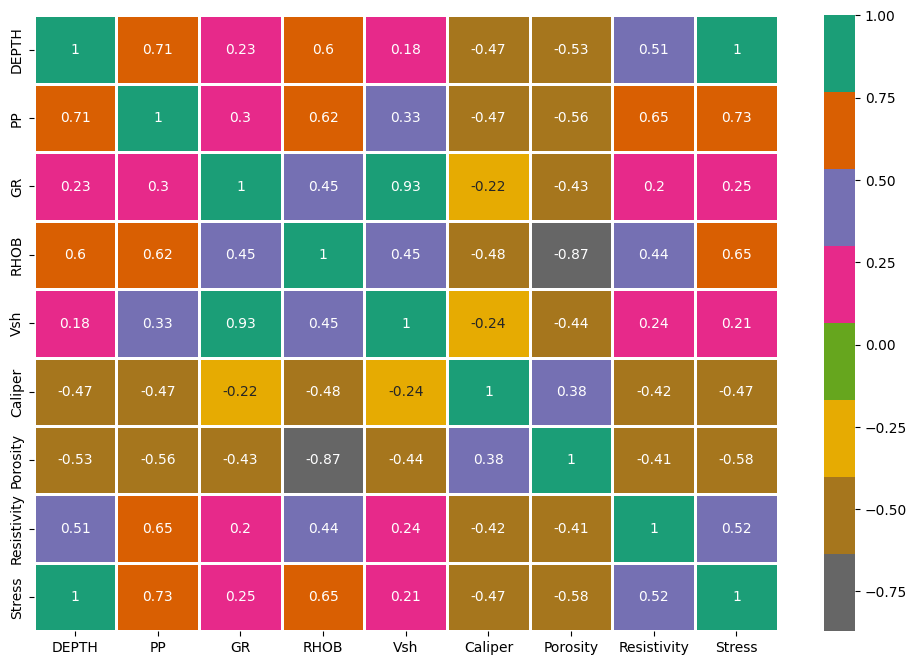

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(a.corr(), annot=True, cmap='Dark2_r', linewidths=2)
plt.show()

In [22]:
x = a.drop(['PP', 'DEPTH'], axis=1)  # independent variables
y = a['PP']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

print("Training data size:", x_train.shape)
print("Testing data size:", x_test.shape)

Training data size: (8326, 7)
Testing data size: (2082, 7)


### We will be using the following models:
- Linear Regression
- Random Forest Regressor
- XGB Regressor
- SVM Regressor



Linear Regression

Mean Squared Error (MSE): 14416.857029004264
Root Mean Squared Error (RMSE): 120.07021707735963
Mean Absolute Error (MAE): 93.10131083008797
R^2  Score: 0.6676129338187422
Coefficients: [-297.43510232  123.38338375  332.52928266  -40.15254195  -46.89092057
  361.05216309  447.15782287]
Intercept: 1489.5855597209775


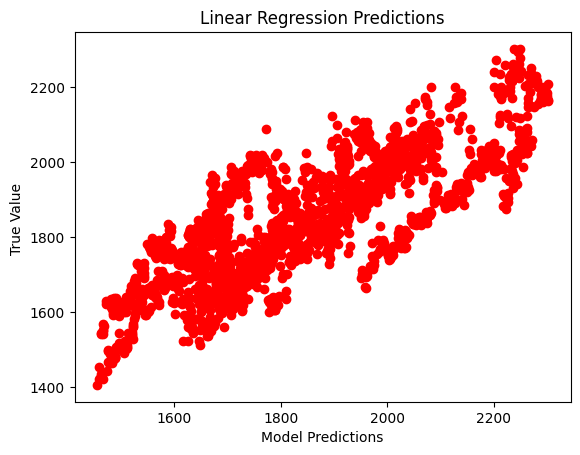

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2  Score:", r2)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

plt.plot(y_test, y_pred, "o", color='r')


plt.xlabel("Model Predictions")
plt.ylabel("True Value ")
plt.title('Linear Regression Predictions')
plt.show()

 Linear Regrsession model has not performed well.

## Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

rf_acc = r2_score(y_test, y_pred)
print("R^2", rf_acc)
print("Adusted R^2", 1-(1-r2_score(y_test, y_pred)) *
      (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 0.9503693175970215
Adusted R^2 0.9502018080614281
MAE 25.641595869836703
MSE 2152.666349735375
RMSE 46.39683555734567


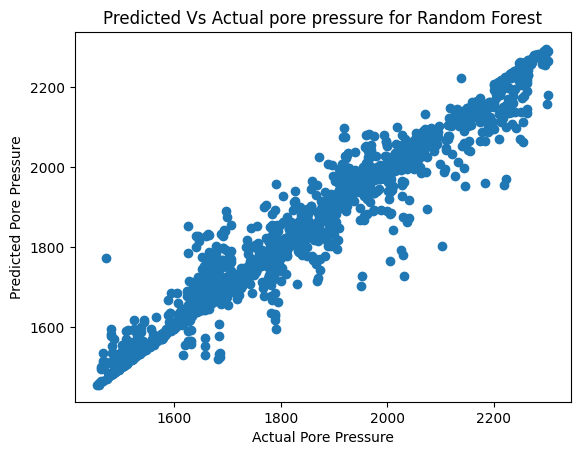

In [25]:
# visualization
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Pore Pressure")
plt.ylabel("Predicted Pore Pressure")
plt.title("Predicted Vs Actual pore pressure for Random Forest")
plt.show()

## XGB Regressor

In [26]:
from xgboost import XGBRegressor

xreg = XGBRegressor()
xreg.fit(x_train, y_train)
y_pred = xreg.predict(x_test)
xgb_acc = r2_score(y_test, y_pred)
print("R^2", rf_acc)
print("Adusted R^2", 1-(1-r2_score(y_test, y_pred)) *
      (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 0.9503693175970215
Adusted R^2 0.9432616878425577
MAE 32.96367858288679
MSE 2452.6724880447546
RMSE 49.52446353111515


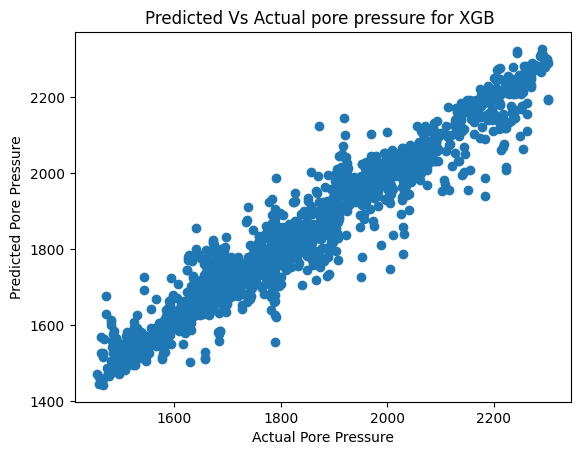

In [27]:
# visualization
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Pore Pressure")
plt.ylabel("Predicted Pore Pressure")
plt.title("Predicted Vs Actual pore pressure for XGB ")
plt.show()

In [28]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R_squared Score': [r2*100, rf_acc*100, xgb_acc*100]
})
models.sort_values(by='R_squared Score', ascending=False)

,Model,R_squared Score
1,Random Forest,95.036932
2,XGBoost,94.345254
0,Linear Regression,66.761293


## Hypertuning

Random Forest

In [ ]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

rf_search.fit(x_train, y_train)
print("Best RF Parameters:", rf_search.best_params_)

rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(x_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest R²: {r2_rf:.3f}")

Best RF Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Random Forest MAE: 36.025
Random Forest RMSE: 54.349
Random Forest R²: 0.932


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Default model
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(x_train, y_train)
default_r2 = r2_score(y_test, rf_default.predict(x_test))
print(f"Default RF R² on test set: {default_r2:.3f}")

# Cross-validation with shuffling for robustness
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_default = cross_val_score(rf_default, x, y, cv=kf, scoring='r2')
print(f"Default RF mean CV R²: {cv_scores_default.mean():.3f}")

# Tuned model
rf_best = rf_search.best_estimator_
tuned_r2 = r2_score(y_test, rf_best.predict(x_test))
print(f"Tuned RF R² on test set: {tuned_r2:.3f}")

cv_scores_tuned = cross_val_score(rf_best, x, y, cv=kf, scoring='r2')
print(f"Tuned RF mean CV R²: {cv_scores_tuned.mean():.3f}")

Default RF R² on test set: 0.949
Default RF mean CV R²: 0.951
Tuned RF R² on test set: 0.931
Tuned RF mean CV R²: 0.932


XGBoost 

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)
xgb_search.fit(x_train, y_train)


print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Lowest RMSE found:", np.sqrt(np.abs(xgb_search.best_score_)))

xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(x_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.3f}")
print(f"XGBoost RMSE: {rmse_xgb:.3f}")
print(f"XGBoost R²: {r2_xgb:.3f}")

Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Lowest RMSE found: 54.80168920118167
XGBoost MAE: 36.248
XGBoost RMSE: 53.359
XGBoost R²: 0.934


The default Random Forest model initially achieved an R² of 0.95 on the test set, but after hyperparameter tuning, both the Random Forest and XGBoost models demonstrated consistent and robust performance, each achieving an R² of approximately 0.93